<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/direct_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DirectSolver

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
# from torchdyn.numerics.solvers import SolverTemplate

In [4]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None


In [5]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[..., 0]
    s = x[..., 1]
    p = x[..., 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [6]:
# initial condtions for training
n_training = 100
x0_train = (
    torch.tensor(lhs(3, n_training), device='cpu') 
) 
x0_train[:,0] = x0_train[:,0] * 10 + 0.2 # biomass (0.2-10.2)
x0_train[:,1] = x0_train[:,1]* 40 # substrate (0-40)
x0_train[:,2] = x0_train[:,2]* 40 # product (0-40)

In [7]:
# condiciones iniciales para la validación de la red
n_validation = 10
x0_validate = (
    torch.tensor(lhs(3, n_validation), device='cpu') 
)
x0_validate[:,0] = x0_validate[:,0] + 0.2 # biomass (0.2-1.2)
x0_validate[:,1] = x0_validate[:,1]* 20 + 20 # substrate (20-40)
x0_validate[:,2] = x0_validate[:,2]* 0 # product (0)

In [8]:
# training time are time intervals of 1 hour
step_size_train = 1
ε = 1e-10 
t_span_train = torch.arange(
    0.0, 
    1 + ε,
    step_size_train
)

# validation time are time intervals of 60 hours
t_span_validate = torch.arange(
    0.0,
    60 + ε,
    step_size_train
)

In [10]:
# Calculate state at hour 1 with training data
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")


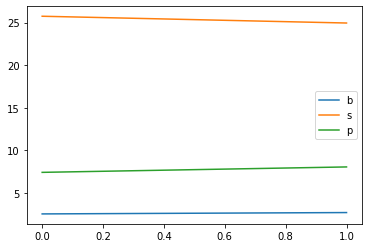

In [12]:
# en la trayectoría número 10 así cambia la biomasa, el sustrato y el producto en un intervalo de 1 hora
traj = 10
plt.plot(x_train[:, traj, 0], label='b')
plt.plot(x_train[:, traj, 1], label='s')
plt.plot(x_train[:, traj, 2], label='p')
plt.legend()

In [13]:
# Calculate trajectory for initial conditions in validation data
# This is equivalen to experimental data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

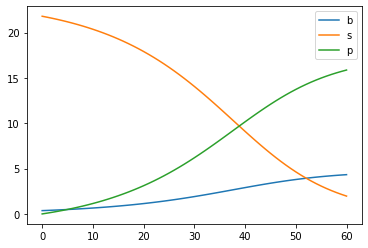

In [14]:
# trayectoría de validación 'real' número 3
traj = 3
plt.plot(x_validate[:, traj, 0], label = 'b')
plt.plot(x_validate[:, traj, 1], label = 's')
plt.plot(x_validate[:, traj, 2], label = 'p')
plt.legend()

In [15]:
# Define model
def model(input_dim, output_dim):
    layers = []
    layers.append(nn.Linear(input_dim, 32))
    for _ in range(8):
        layers.append(nn.Linear(32, 32)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(32, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [41]:
# Create model
net = model(3, 3)

In [42]:
# training algorithm
optimizer = Adam(net.parameters()) 

In [43]:
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=DirectSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() # iterar para cambiar los pesos de acuerdo a las derivadas

    # Validation data
    net.eval()
    with torch.inference_mode():

        # 1. Forward pass
        _, x_pred_validate = odeint(
            lambda t, x: net(x), 
            x0_validate, 
            t_span_validate, 
            solver=DirectSolver()
        )

        # 2. Calculate loss
        loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} | Test loss: {loss_val}")


    losses.append(loss.item())

  0%|          | 9/2000 [00:00<00:50, 39.26it/s]

Epoch: 0 | Training loss: 169.3180073173885 | Test loss: 177.13294634905387


  3%|▎         | 57/2000 [00:01<00:45, 42.28it/s]

Epoch: 50 | Training loss: 20.137944373840675 | Test loss: 123.25216149988492


  5%|▌         | 105/2000 [00:02<00:51, 36.47it/s]

Epoch: 100 | Training loss: 2.3506799088743326 | Test loss: 83.23271834124662


  8%|▊         | 159/2000 [00:03<00:44, 41.40it/s]

Epoch: 150 | Training loss: 1.672343220869469 | Test loss: 35.18448948738985


 10%|█         | 204/2000 [00:05<00:47, 37.98it/s]

Epoch: 200 | Training loss: 0.2531527980394854 | Test loss: 46.02005024792781


 13%|█▎        | 253/2000 [00:06<01:17, 22.49it/s]

Epoch: 250 | Training loss: 0.044547556897617246 | Test loss: 29.51753359915079


 15%|█▌        | 306/2000 [00:09<01:06, 25.42it/s]

Epoch: 300 | Training loss: 0.033070332181567026 | Test loss: 100.52281146720924


 18%|█▊        | 354/2000 [00:11<01:05, 25.01it/s]

Epoch: 350 | Training loss: 0.010826550059802424 | Test loss: 59.843392629099824


 20%|██        | 409/2000 [00:12<00:38, 41.37it/s]

Epoch: 400 | Training loss: 0.007567555770069162 | Test loss: 97.97139588250836


 23%|██▎       | 459/2000 [00:13<00:36, 42.55it/s]

Epoch: 450 | Training loss: 0.00549288885168333 | Test loss: 44.199550218800155


 25%|██▌       | 509/2000 [00:15<00:36, 40.73it/s]

Epoch: 500 | Training loss: 0.04037237728685893 | Test loss: 44.23530493459249


 28%|██▊       | 559/2000 [00:16<00:34, 41.39it/s]

Epoch: 550 | Training loss: 0.003683295080140779 | Test loss: 36.002485014582156


 30%|███       | 609/2000 [00:17<00:34, 40.26it/s]

Epoch: 600 | Training loss: 0.0037525447441366508 | Test loss: 25.74349877902491


 33%|███▎      | 659/2000 [00:18<00:31, 42.86it/s]

Epoch: 650 | Training loss: 0.00334238908275699 | Test loss: 46.358702785533076


 35%|███▌      | 709/2000 [00:20<00:31, 41.39it/s]

Epoch: 700 | Training loss: 0.002366871613297404 | Test loss: 29.618784086558847


 38%|███▊      | 759/2000 [00:21<00:29, 42.62it/s]

Epoch: 750 | Training loss: 0.005882993368852062 | Test loss: 26.841934743209137


 40%|████      | 809/2000 [00:22<00:28, 41.71it/s]

Epoch: 800 | Training loss: 0.0019918198279771635 | Test loss: 32.00432858555891


 43%|████▎     | 859/2000 [00:23<00:26, 42.45it/s]

Epoch: 850 | Training loss: 0.0016549426065779497 | Test loss: 24.358697803430733


 45%|████▌     | 908/2000 [00:24<00:27, 40.37it/s]

Epoch: 900 | Training loss: 0.04537574232076532 | Test loss: 78.79188266153409


 48%|████▊     | 958/2000 [00:25<00:24, 42.93it/s]

Epoch: 950 | Training loss: 0.001878631673838264 | Test loss: 19.62126725312138


 50%|█████     | 1007/2000 [00:27<00:23, 41.40it/s]

Epoch: 1000 | Training loss: 0.001288750494569612 | Test loss: 17.062945216956344


 53%|█████▎    | 1055/2000 [00:28<00:24, 38.84it/s]

Epoch: 1050 | Training loss: 0.001170886089895168 | Test loss: 15.33452222173646


 55%|█████▌    | 1105/2000 [00:29<00:22, 40.15it/s]

Epoch: 1100 | Training loss: 0.0010766345151973884 | Test loss: 13.38056668341097


 58%|█████▊    | 1155/2000 [00:30<00:20, 41.16it/s]

Epoch: 1150 | Training loss: 0.0014247509624135907 | Test loss: 18.381202759860535


 60%|██████    | 1208/2000 [00:32<00:19, 40.32it/s]

Epoch: 1200 | Training loss: 0.0010692844929992855 | Test loss: 13.025677514746071


 63%|██████▎   | 1254/2000 [00:33<00:22, 33.53it/s]

Epoch: 1250 | Training loss: 0.0009756309157450072 | Test loss: 9.527225653028982


 65%|██████▌   | 1305/2000 [00:34<00:19, 36.08it/s]

Epoch: 1300 | Training loss: 0.0009100924251033582 | Test loss: 8.977819978208524


 68%|██████▊   | 1358/2000 [00:36<00:15, 41.02it/s]

Epoch: 1350 | Training loss: 0.0009080519699932806 | Test loss: 13.194233839532995


 70%|███████   | 1408/2000 [00:37<00:13, 42.35it/s]

Epoch: 1400 | Training loss: 0.0009450832715572001 | Test loss: 7.133812032496274


 73%|███████▎  | 1457/2000 [00:38<00:13, 38.81it/s]

Epoch: 1450 | Training loss: 0.022309885177521253 | Test loss: 42.819956754762465


 75%|███████▌  | 1509/2000 [00:40<00:12, 38.45it/s]

Epoch: 1500 | Training loss: 0.0008528829372102041 | Test loss: 5.776651616600292


 78%|███████▊  | 1559/2000 [00:41<00:10, 42.20it/s]

Epoch: 1550 | Training loss: 0.0007478376634203643 | Test loss: 7.210030909043881


 80%|████████  | 1609/2000 [00:42<00:09, 41.46it/s]

Epoch: 1600 | Training loss: 0.02363215715283322 | Test loss: 76.8949344049838


 83%|████████▎ | 1659/2000 [00:43<00:08, 42.55it/s]

Epoch: 1650 | Training loss: 0.001333186297186905 | Test loss: 21.060543965149563


 85%|████████▌ | 1707/2000 [00:44<00:08, 35.64it/s]

Epoch: 1700 | Training loss: 0.0007185916190712938 | Test loss: 6.1683905080906785


 88%|████████▊ | 1758/2000 [00:46<00:06, 40.27it/s]

Epoch: 1750 | Training loss: 0.0006753986118364173 | Test loss: 6.52576602599608


 90%|█████████ | 1806/2000 [00:47<00:04, 40.25it/s]

Epoch: 1800 | Training loss: 0.0016692274056679468 | Test loss: 8.29269240622396


 93%|█████████▎| 1856/2000 [00:48<00:03, 42.02it/s]

Epoch: 1850 | Training loss: 0.0019521109931963964 | Test loss: 8.676265270595305


 95%|█████████▌| 1906/2000 [00:49<00:02, 41.91it/s]

Epoch: 1900 | Training loss: 0.0013122850055661394 | Test loss: 5.766577688500669


 98%|█████████▊| 1955/2000 [00:51<00:01, 41.39it/s]

Epoch: 1950 | Training loss: 0.0006273013266005099 | Test loss: 5.862873080140093


100%|██████████| 2000/2000 [00:52<00:00, 38.38it/s]


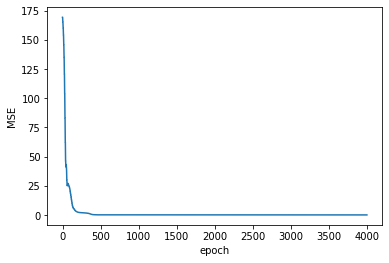

In [44]:
# show loss evolution
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
plt.show()

In [45]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=DirectSolver()
    ) 

In [47]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [48]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [49]:
def plot_predictions(i=0):

    print("Validación", i)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, i, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, i, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, 0, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[..., i, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[..., i, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[..., i, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validación 9


<ipython-input-49-e712e503c587>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-49-e712e503c587>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-49-e712e503c587>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

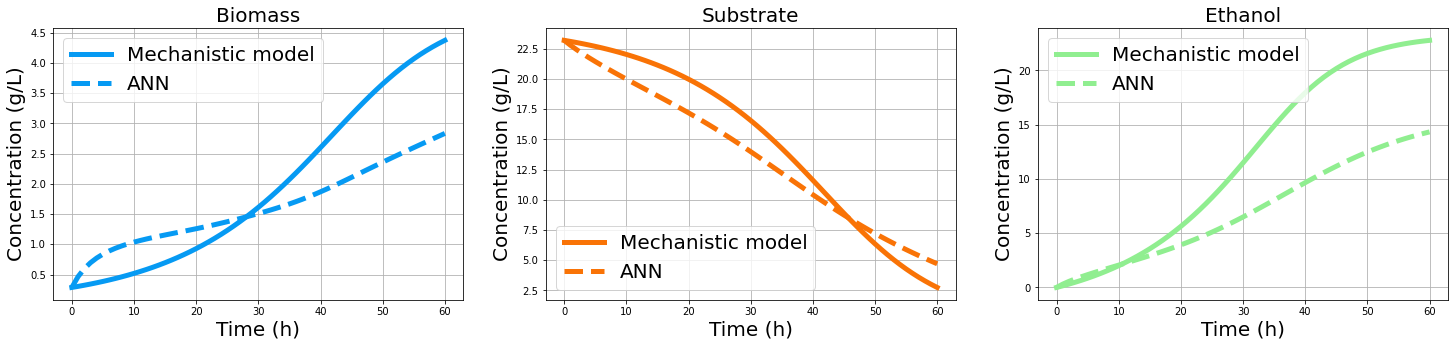

In [54]:
plot_predictions(9)